In [1]:
%%capture
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install pip3-autoremove
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install unsloth
!pip install --upgrade transformers==4.53.2 "huggingface_hub>=0.34.0" "datasets>=3.4.1,<4.0.0"

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-03 18:58:51.394265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754247531.749870      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754247531.846664      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.1: Fast Gemma3 patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.38G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [4]:
DATA_ROOT   = "/kaggle/input/ffruit2-data/dataset"          # 数据文件夹
TRAIN_JSONL = f"{DATA_ROOT}/_annotations.train.jsonl"
CLASS_NAMES = ["apple", "banana", "pear", "waterme"] # 类别顺序

# ╔══ 2. 读取原始 JSONL (image/prefix/suffix) ═══╗
from pathlib import Path
from datasets import load_dataset, Features, Value, Image as DImage

raw_feat = Features({
    "image" : Value("string"),   # 先当字符串
    "prefix": Value("string"),
    "suffix": Value("string"),
})
ds = load_dataset("json",
                  data_files=TRAIN_JSONL,
                  split="train",
                  features=raw_feat)
print("Loaded", len(ds), "samples")

Generating train split: 0 examples [00:00, ? examples/s]

Loaded 953 samples


In [5]:
import re
LOC_PAT = re.compile(r"<loc\d{4}>")

def count_objects(suffix:str) -> dict:
    """直接在 suffix 里统计每个类别出现次数"""
    return {cls: suffix.count(cls) for cls in CLASS_NAMES}

def loc2sentence(counts:dict) -> str:
    return "; ".join([f"{v} {k}" for k,v in counts.items() if v]) or "no object"

# ╔══ 4. 转成对话格式 ═══╗
def to_conversation(ex):
    img_path = str(Path(DATA_ROOT) / ex["image"])        # 绝对路径
    counts   = count_objects(ex["suffix"])
    answer   = loc2sentence(counts)

    ex["image"] = img_path                               # 顶层仍是字符串
    ex["messages"] = [
        {"role":"user",
         "content":[
             {"type":"text", "text":"What fruits are in this image?"},
             {"type":"image","image": img_path},          # 占位即可
         ]},
        {"role":"assistant",
         "content":[
             {"type":"text","text": answer},
         ]},
    ]
    return ex

ds = (ds.map(to_conversation,
             remove_columns=["prefix","suffix"],
             batched=False)
        .cast_column("image", DImage()))                  # 顶层 image → PIL


Map:   0%|          | 0/953 [00:00<?, ? examples/s]

assistant answer → 1 apple; 1 banana; 1 pear; 1 waterme


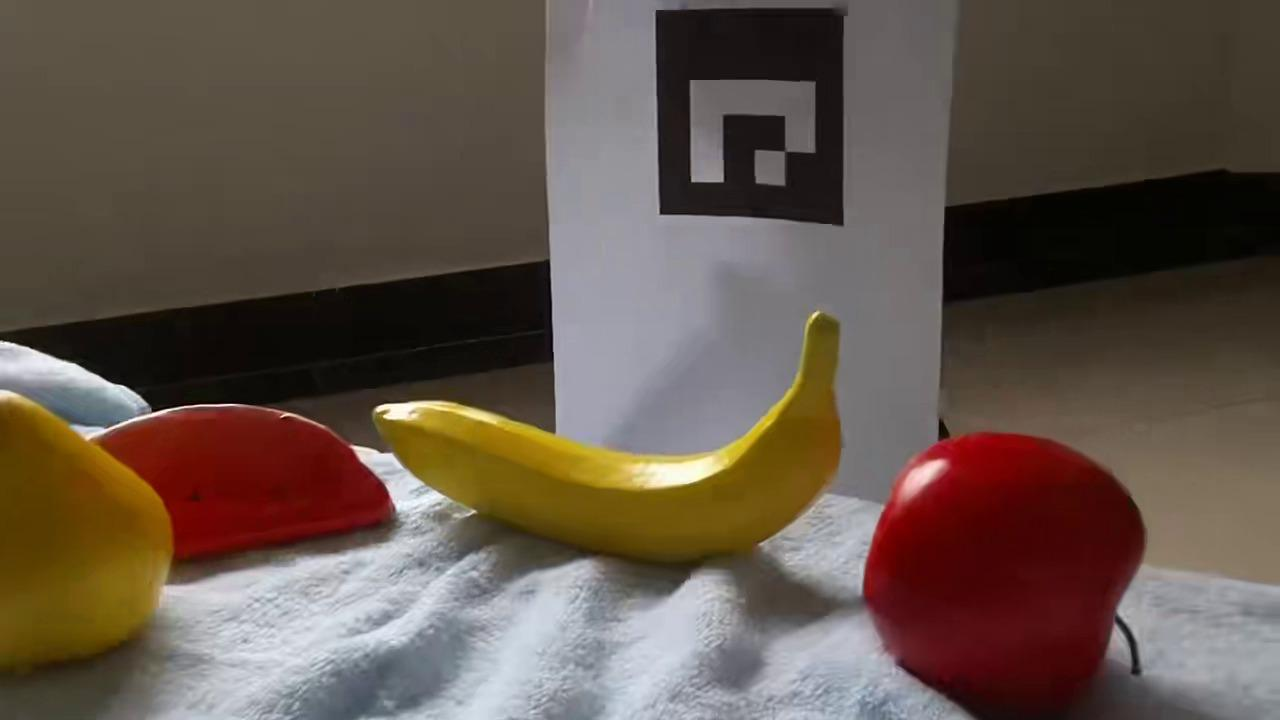

In [6]:
from PIL import Image as PILImage
sample = ds[0]
print("assistant answer →", sample["messages"][1]["content"][0]["text"])
assert isinstance(sample["image"], PILImage.Image)

display(sample["image"])         # 显示缩略图

In [7]:
ds[800]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'messages': [{'content': [{'image': None,
     'text': 'What fruits are in this image?',
     'type': 'text'},
    {'image': '/kaggle/input/ffruit2-data/dataset/c79c8a7735d06cfcc169ee7284bd7569_000210_jpg.rf.1c3c478a29ae79223a75a2a61d4ee454.jpg',
     'text': None,
     'type': 'image'}],
   'role': 'user'},
  {'content': [{'image': None, 'text': '1 banana', 'type': 'text'}],
   'role': 'assistant'}]}

In [8]:
from unsloth import get_chat_template
processor = get_chat_template(processor, "gemma-3")  # 加指令模板

In [9]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma3ForConditionalGeneration(
      (model): Gemma3Model(
        (vision_tower): SiglipVisionModel(
          (vision_model): SiglipVisionTransformer(
            (embeddings): SiglipVisionEmbeddings(
              (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
              (position_embedding): Embedding(4096, 1152)
            )
            (encoder): SiglipEncoder(
              (layers): ModuleList(
                (0-26): 27 x SiglipEncoderLayer(
                  (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                  (self_attn): SiglipAttention(
                    (k_proj): lora.Linear(
                      (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Identity()
                      )
                      (lora_A): ModuleDict(
  

In [10]:
sft_args = SFTConfig(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    gradient_checkpointing      = True,
    gradient_checkpointing_kwargs = {"use_reentrant": False},
    num_train_epochs = 2,

    #max_steps     = 60,         # 或注释掉改用 num_train_epochs=2
    learning_rate = 2e-4,
    warmup_ratio  = 0.03,
    max_grad_norm = 0.3,

    logging_steps   = 1,
    save_strategy   = "steps",
    optim           = "adamw_torch_fused",
    weight_decay    = 0.01,
    lr_scheduler_type = "cosine",

    seed        = 3407,
    output_dir  = "outputs",    # 保存权重目录
    report_to   = "none",

    # -- Vision 必须 --
    remove_unused_columns = False,
    dataset_text_field    = "",                   # 不能留默认 "text"
    dataset_kwargs        = {"skip_prepare_dataset": True},
    max_length            = 2048,
)

In [11]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer
import copy, torch

class SafeVisionCollator:
    """
    Wrap 原版 UnslothVisionDataCollator;
    在送进去之前，把 type=='text' 的 chunk 里多余的 'image' 键干掉。
    """
    def __init__(self, model, processor):
        self.inner = UnslothVisionDataCollator(model, processor)

    def __call__(self, features):
        # ⚑ 深拷贝避免改原对象
        safe_feats = copy.deepcopy(features)
        for feat in safe_feats:
            for msg in feat["messages"]:
                for chunk in msg["content"]:
                    if chunk.get("type") == "text" and "image" in chunk:
                        chunk.pop("image", None)
        return self.inner(safe_feats)

# ─── 用新的 Collator 训练 ─────────────────────────────
safe_collator = SafeVisionCollator(model, processor)

In [12]:
trainer = SFTTrainer(
    model             = model,
    train_dataset     = ds,        # 仍用之前准备好的 ds_clean
    processing_class  = processor.tokenizer,
    data_collator     = safe_collator,   # ← 换成安全版
    args              = sft_args,
)

Unsloth: Switching to float32 training since model cannot work with float16


In [13]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 953 | Num Epochs = 2 | Total steps = 478
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,7.088100
2,7.518800
3,7.304200
4,7.290400
5,7.514400
6,7.390600
7,5.806700
8,5.593700
9,6.066900
10,4.712900


TrainOutput(global_step=478, training_loss=0.23795378589944205, metrics={'train_runtime': 5784.0475, 'train_samples_per_second': 0.33, 'train_steps_per_second': 0.083, 'total_flos': 1.2035924614327488e+16, 'train_loss': 0.23795378589944205})

In [14]:
model.save_pretrained_merged(
    "fruit_3",       # ← 会创建 ./fruit_fp16/ 并写入 safetensors
    processor           # tokenizer / processor 一起保存
)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [00:39<00:39, 39.48s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [01:06<00:00, 33.05s/it]


In [15]:
%%bash

# 核心修复：首先强制切换到已知存在的工作目录，让Shell“脚踏实地”
cd /kaggle/working/

# 现在，当前目录是有效的，可以安全地执行克隆命令
echo "正在从官方地址克隆最新的 llama.cpp..."
git clone https://github.com/ggml-org/llama.cpp.git

# 检查一下是否成功
echo "克隆完毕，检查文件列表："
ls -lh

正在从官方地址克隆最新的 llama.cpp...
克隆完毕，检查文件列表：
total 868K
drwxr-xr-x  3 root root 4.0K Aug  3 20:37 fruit_3
drwxr-xr-x 25 root root 4.0K Aug  3 20:38 llama.cpp
----------  1 root root 849K Aug  3 20:37 __notebook__.ipynb
drwxr-xr-x  3 root root 4.0K Aug  3 20:36 outputs
drwxr-xr-x  3 root root 4.0K Aug  3 18:59 unsloth_compiled_cache


Cloning into 'llama.cpp'...


In [16]:
%%bash
cd /kaggle/working/llama.cpp && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/nightly, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/nightly, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/nightly
Ignoring torch: markers 'platform_machine == "s390x"' don't match your environment
Ignoring torch: markers 'platform_machine == "s390x"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.54.1-py3-none-any.whl.metadata (41 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s et

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
xformers 0.0.29.post3 requires torch==2.6.0, but you have torch 2.2.2+cpu which is incompatible.
unsloth 2025.8.1 requires huggingface_hub>=0.34.0, but you have huggingface-hub 0.23.5 which is incompatible.
unsloth 2025.8.1 requires torch>=2.4.0, but you have torch 2.2.2+cpu which is incompatible.
unsloth 2025.8.1 requires transformers!=4.47.0,!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,>=4.51.3, but you have transformers 4.46.3 which is incompatible.
unsloth-zoo 2025.8.1 requires huggingface_hub>=0.34.0, but you have huggingface-hub 0.23.5 which is incompatible.
unsloth-zoo 2025.8.1 requires torch>=2.4.0, but you have torch 2.2.2+cpu which is incompatible.
unsloth-zoo 2025.8.1 requires transformers!=4.47.0,!=4.52.0,!=4

In [17]:
%%bash

# 确保我们回到一个“干净”的根目录
cd /kaggle/working/

# -- 重要 --
# 我们不再尝试进入 llama.cpp 目录，
# 而是直接从 /kaggle/working/ 这个位置，调用里面的脚本
# 这样可以绕过 cd 命令失败的问题

echo "开始执行转换..."
python llama.cpp/convert_hf_to_gguf.py \
  fruit_3/ \
  --outtype q8_0 \
  --mmproj \
  --outfile mmproj-fruit_3.gguf

echo "命令执行完毕。"

开始执行转换...
命令执行完毕。


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
Writing: 100%|██████████| 591M/591M [00:09<00:00, 61.7Mbyte/s]


In [18]:
%%bash

# 确保我们回到一个“干净”的根目录
cd /kaggle/working/

# -- 重要 --
# 我们不再尝试进入 llama.cpp 目录，
# 而是直接从 /kaggle/working/ 这个位置，调用里面的脚本
# 这样可以绕过 cd 命令失败的问题

echo "开始执行转换..."
python llama.cpp/convert_hf_to_gguf.py \
  fruit_3/ \
  --outtype q8_0 \
  --outfile fruit_3.gguf

echo "命令执行完毕。"

开始执行转换...
命令执行完毕。


Writing: 100%|██████████| 4.12G/4.12G [01:53<00:00, 36.3Mbyte/s]


In [19]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))

/kaggle/working
['fruit_3', 'unsloth_compiled_cache', 'outputs', 'fruit_3.gguf', 'mmproj-fruit_3.gguf', 'llama.cpp', '__notebook__.ipynb']


In [20]:
from IPython.display import FileLink
FileLink('mmproj-fruit_3.gguf')

/kaggle/working/mmproj-fruit_3.gguf

In [21]:
from IPython.display import FileLink
FileLink('fruit_3.gguf')

/kaggle/working/fruit_3.gguf